## 8. Putting it all together with a multi-class classification problem

* Binary classification = one thing or another (cat vs. dog, spam vs. not spam, fraud or not fraud)
* Multi-class classification = more than one thing or another (cat vs. dog vs. chicken)

### 8.1 Creating a toy multi-class dataset

X_blob shape: torch.Size([1000, 2])


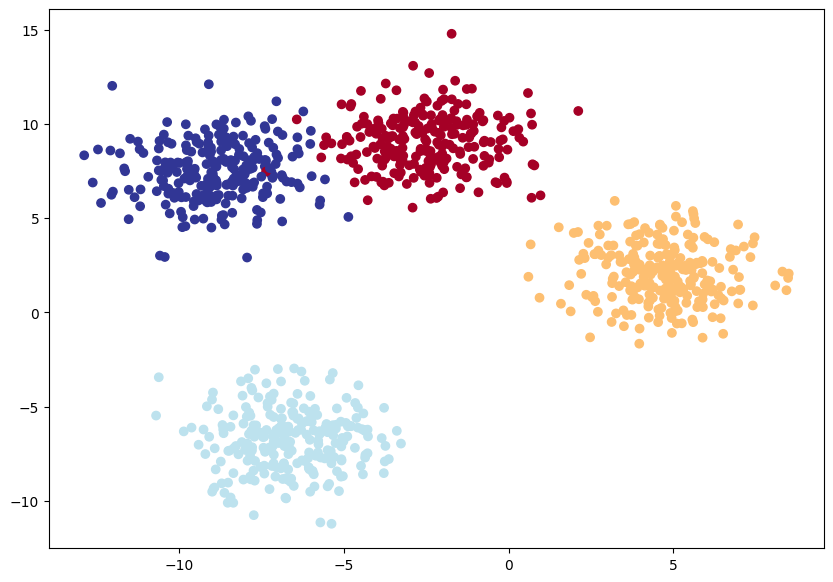

In [1]:
# Import dependencies 
import torch
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs # https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_blobs.html#sklearn.datasets.make_blobs 
from sklearn.model_selection import train_test_split

# Set the hyperparameters for data creation
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

# 1. Create multi-class data
X_blob, y_blob = make_blobs(n_samples=1000,
                            n_features=NUM_FEATURES,
                            centers=NUM_CLASSES,
                            cluster_std=1.5, # give the clusters a little shake up
                            random_state=RANDOM_SEED)

# 2. Turn data into tensors
X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)

# 3. Split into train and test
X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob,
                                                                        y_blob,
                                                                        test_size=0.2, 
                                                                        random_state=RANDOM_SEED)

# 4. Plot data (visualize, visualize, visualize)
plt.figure(figsize=(10, 7))
plt.scatter(X_blob[:, 0], X_blob[:, 1], c=y_blob, cmap=plt.cm.RdYlBu);

print("X_blob shape:", X_blob.shape)

### 8.2 Building a multi-class classification model in PyTorch

In [2]:
# Create device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

import torch
from torch import nn

cpu


In [3]:
# Build a multi-class classification model
class BlobModel(nn.Module):
  def __init__(self, input_features, output_features, hidden_units=8):
    """Initializes multi-class classification model.
    
    Args:
      input_features (int): Number of input features to the model
      output_features (int): Number of outputs features (number of output classes)
      hidden_units (int): Number of hidden units between layers, default 8

    Returns:

    Example:
    """
    super().__init__()
    self.linear_layer_stack = nn.Sequential(
        nn.Linear(in_features=input_features, out_features=hidden_units),
        # nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=hidden_units),
        # nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=output_features)
    )

  def forward(self, x):
    return self.linear_layer_stack(x)

# Create an instance of BlobModel and send it to the target device
model_4 = BlobModel(input_features=2,
                    output_features=4,
                    hidden_units=8).to(device)

print(model_4)

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): Linear(in_features=8, out_features=8, bias=True)
    (2): Linear(in_features=8, out_features=4, bias=True)
  )
)


In [4]:
print(X_blob_train.shape)
print(y_blob_train[:5])

torch.Size([800, 2])
tensor([1, 0, 2, 2, 0])


In [5]:
print(torch.unique(y_blob_train))

tensor([0, 1, 2, 3])


### 8.3 Create a loss function and an optimizer for a multi-class classification model

In [6]:
# Create a loss function for multi-class classification - loss function measures how wrong our model's predictions are
loss_fn = nn.CrossEntropyLoss()

# Create an optimizer for multi-class classification - optimizer updates our model parameters to try and reduce the loss
optimizer = torch.optim.SGD(params=model_4.parameters(), 
                            lr=0.1) # learning rate is a hyperparameter you can change

### 8.4 Getting prediction probabilities for a multi-class PyTorch model

In order to evaluate and train and test our model, we need to convert our model's outputs (logtis) to predicition probabilities and then to prediction labels.

Logits (raw output of the model) -> Pred probs (use `torch.softmax`) -> Pred labels (take the argmax of the prediction probabilities)

In [7]:
# Let's get some raw outputs of our model (logits)
model_4.eval()
with torch.inference_mode():
  y_logits = model_4(X_blob_test.to(device))

print(y_logits[:10])

tensor([[ 1.1545,  0.3033, -0.1190,  0.6316],
        [ 0.2372, -0.0772, -1.6577, -1.1254],
        [-0.8785, -0.2187,  0.3197, -1.1806],
        [ 0.7824,  0.2269,  0.1906,  0.4239],
        [ 1.2166,  0.2227, -1.2885,  0.0616],
        [ 0.1659, -0.1214, -1.9516, -1.3563],
        [-0.7783, -0.1683,  0.5928, -0.9318],
        [ 0.9389,  0.1413, -1.3493, -0.2513],
        [-1.1100, -0.3098, -0.0098, -1.5921],
        [ 1.0278,  0.1696, -1.3027, -0.1364]])


In [8]:
print(y_blob_test[:10])

tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0])


In [9]:
# Convert our model's logit outputs to prediction probabilities
y_pred_probs = torch.softmax(y_logits, dim=1)
print(y_logits[:5])
print(y_pred_probs[:5])

tensor([[ 1.1545,  0.3033, -0.1190,  0.6316],
        [ 0.2372, -0.0772, -1.6577, -1.1254],
        [-0.8785, -0.2187,  0.3197, -1.1806],
        [ 0.7824,  0.2269,  0.1906,  0.4239],
        [ 1.2166,  0.2227, -1.2885,  0.0616]])
tensor([[0.4349, 0.1856, 0.1217, 0.2578],
        [0.4680, 0.3418, 0.0704, 0.1198],
        [0.1431, 0.2768, 0.4743, 0.1058],
        [0.3539, 0.2031, 0.1958, 0.2473],
        [0.5660, 0.2095, 0.0462, 0.1783]])


In [10]:
# Convert our model's prediction probabilities to prediction labels
y_preds = torch.argmax(y_pred_probs, dim=1)
print(y_preds)

tensor([0, 0, 2, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2,
        2, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 2, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 2, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 1, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 2, 2, 0, 0, 0, 0, 1,
        2, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2,
        2, 2, 0, 0, 0, 1, 2, 0, 0, 1, 0, 0, 0, 0, 2, 0, 2, 0, 0, 2, 0, 0, 2, 0,
        2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 2, 2, 0, 0, 2, 2, 0, 0,
        0, 0, 2, 0, 0, 0, 2, 0])


In [11]:
print(y_blob_test)

tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0, 0, 1, 0, 0, 0, 3, 3, 2, 3, 3, 3, 0, 1, 2,
        2, 2, 3, 0, 1, 0, 3, 1, 1, 3, 1, 2, 1, 3, 0, 2, 0, 3, 3, 2, 0, 3, 1, 1,
        0, 3, 1, 0, 1, 1, 3, 2, 1, 1, 3, 2, 2, 0, 3, 2, 2, 0, 0, 3, 3, 0, 0, 3,
        3, 3, 2, 3, 3, 3, 3, 1, 0, 2, 3, 2, 3, 3, 2, 3, 3, 2, 3, 3, 1, 3, 3, 3,
        1, 0, 3, 2, 0, 0, 3, 0, 2, 3, 1, 0, 3, 2, 1, 1, 0, 2, 2, 3, 0, 0, 1, 2,
        2, 3, 0, 1, 2, 0, 0, 0, 2, 3, 1, 2, 3, 2, 0, 3, 0, 0, 1, 1, 1, 0, 2, 2,
        2, 2, 0, 3, 3, 2, 2, 1, 3, 2, 0, 0, 3, 3, 2, 1, 2, 0, 3, 2, 0, 3, 2, 0,
        2, 2, 2, 0, 3, 1, 1, 1, 1, 1, 3, 1, 0, 2, 2, 1, 2, 2, 0, 1, 2, 2, 0, 0,
        1, 3, 2, 0, 3, 1, 2, 1])


### 8.5 Creating a training loop and testing loop for a multi-class PyTorch model

In [12]:
print(y_blob_train.dtype)

# Calculate accuracy - out of 100 examples, what percentage does our model get right? 
def accuracy_fn(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item() 
  acc = (correct/len(y_pred)) * 100
  return acc

torch.int64


In [13]:
# Fit the multi-class model to the data
torch.manual_seed(42)
# torch.cuda.manual_seed(42)

# Set number of epochs 
epochs = 100

# Put data to the target device
X_blob_train, y_blob_train = X_blob_train.to(device), y_blob_train.to(device)
X_blob_test, y_blob_test = X_blob_test.to(device), y_blob_test.to(device)

# Loop through data
for epoch in range(epochs):
  ### Training 
  model_4.train()

  y_logits = model_4(X_blob_train)
  y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)

  loss = loss_fn(y_logits, y_blob_train)
  acc = accuracy_fn(y_true=y_blob_train,
                    y_pred=y_pred)
  
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  ### Testing
  model_4.eval()
  with torch.inference_mode():
    test_logits = model_4(X_blob_test)
    test_preds = torch.softmax(test_logits, dim=1).argmax(dim=1)
    
    test_loss = loss_fn(test_logits, y_blob_test)
    test_acc = accuracy_fn(y_true=y_blob_test,
                           y_pred=test_preds)
    
  # Print out what's happenin'
  if epoch % 10 == 0:
    print(f"Epoch: {epoch} | Loss: {loss:.4f}, Acc: {acc:.2f}% | Test loss: {test_loss:.4f}, Test acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 1.3326, Acc: 47.88% | Test loss: 0.5705, Test acc: 81.00%
Epoch: 10 | Loss: 0.1725, Acc: 97.12% | Test loss: 0.1409, Test acc: 98.50%
Epoch: 20 | Loss: 0.0842, Acc: 99.00% | Test loss: 0.0754, Test acc: 99.50%
Epoch: 30 | Loss: 0.0617, Acc: 99.00% | Test loss: 0.0538, Test acc: 99.50%
Epoch: 40 | Loss: 0.0509, Acc: 99.12% | Test loss: 0.0430, Test acc: 99.50%
Epoch: 50 | Loss: 0.0446, Acc: 99.12% | Test loss: 0.0366, Test acc: 99.50%
Epoch: 60 | Loss: 0.0406, Acc: 99.12% | Test loss: 0.0324, Test acc: 99.50%
Epoch: 70 | Loss: 0.0378, Acc: 99.12% | Test loss: 0.0294, Test acc: 99.50%
Epoch: 80 | Loss: 0.0357, Acc: 99.12% | Test loss: 0.0272, Test acc: 99.50%
Epoch: 90 | Loss: 0.0342, Acc: 99.12% | Test loss: 0.0255, Test acc: 99.50%


### 8.6 Making and evaluating predictions with a PyTorch multi-class model

In [14]:
# Make predictions
model_4.eval()
with torch.inference_mode():
  y_logits = model_4(X_blob_test)

# View the first 10 predictions
print(y_logits[:10])

tensor([[  6.8507,  12.5139, -11.7318,  -6.7765],
        [  2.2481, -13.8245,   0.4707,   7.9365],
        [-10.0424, -16.8584,  17.6129,   9.2039],
        [  3.3595,   8.8645,  -6.2229,  -4.8416],
        [  9.3769,   4.7003, -13.3191,  -2.2704],
        [  2.1936, -17.1857,   1.3150,   9.8334],
        [ -9.7219, -13.1897,  16.3421,   7.1429],
        [  7.2795,  -0.2219,  -9.3832,   0.4343],
        [-11.3055, -23.0617,  20.7265,  12.6627],
        [  7.9039,   1.5587, -10.6273,  -0.5490]])


In [15]:
# Go from logits -> Prediction probabilities
y_pred_probs = torch.softmax(y_logits, dim=1)
print(y_pred_probs[:10])

tensor([[3.4593e-03, 9.9654e-01, 2.9423e-11, 4.1759e-09],
        [3.3719e-03, 3.5285e-10, 5.7009e-04, 9.9606e-01],
        [9.7580e-13, 1.0696e-15, 9.9978e-01, 2.2282e-04],
        [4.0499e-03, 9.9595e-01, 2.7916e-07, 1.1110e-06],
        [9.9077e-01, 9.2253e-03, 1.3780e-10, 8.6626e-06],
        [4.8058e-04, 1.8427e-12, 1.9962e-04, 9.9932e-01],
        [4.7918e-12, 1.4944e-13, 9.9990e-01, 1.0111e-04],
        [9.9839e-01, 5.5143e-04, 5.7914e-08, 1.0628e-03],
        [1.2261e-14, 9.6135e-20, 9.9969e-01, 3.1463e-04],
        [9.9804e-01, 1.7516e-03, 8.9361e-09, 2.1286e-04]])


In [16]:
# Go from pred probs to pred labels
y_preds = torch.argmax(y_pred_probs, dim=1)
print(y_preds[:10])

tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0])


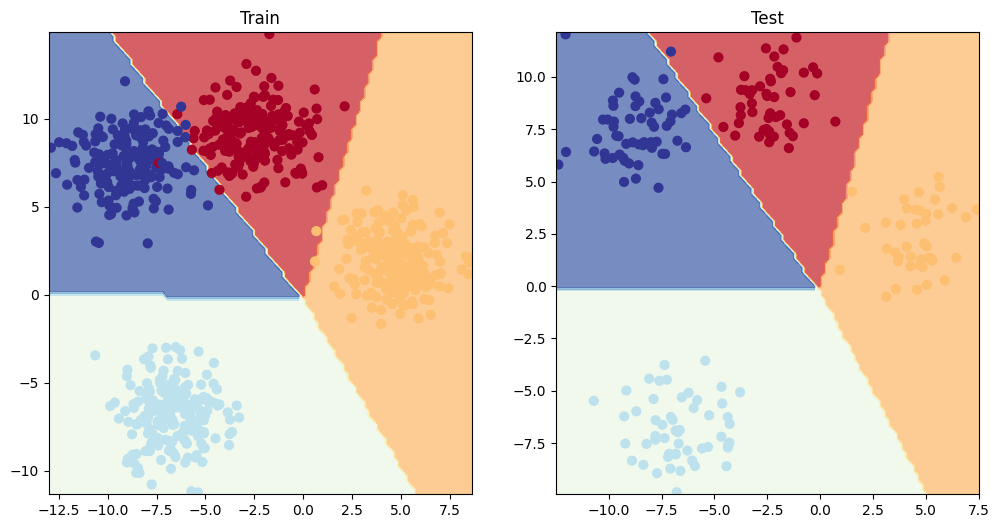

In [17]:
from helper_functions import plot_predictions, plot_decision_boundary

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_4, X_blob_train, y_blob_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_4, X_blob_test, y_blob_test)

## 9. A few more classification metrics... (to evaluate our classification model)

* Accuracy - out of 100 samples, how many does our model get right?
* Precision
* Recall 
* F1-score
* Confusion matrix
* Classification report

See this article for when to use precision/recall - https://towardsdatascience.com/beyond-accuracy-precision-and-recall-3da06bea9f6c

If you want access to a lot of PyTorch metrics, see TorchMetrics - https://torchmetrics.readthedocs.io/en/latest/ 

In [18]:
from torchmetrics import Accuracy

# TODO: Setup metric
# torchmetric_accuracy = Accuracy("multiclass").to(device)
torchmetric_accuracy = Accuracy(task="multiclass", num_classes=NUM_CLASSES).to(device)

# Calculuate accuracy
result = torchmetric_accuracy(y_preds, y_blob_test)
print(result)

tensor(0.9950)


In [19]:
print(torchmetric_accuracy.device)

cpu


## Exercises & Extra-curriculum 

See exercises and extra-curriculum here: https://www.learnpytorch.io/02_pytorch_classification/#exercises